### Sizing ###

The appropriate sizing of a simulation environment is more art than science but we can use several tools in the **RKnot** package to approximate the appropriate attributes and initial conditions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shelve
file = 'tests/data/R0'
# db.close()
db = shelve.open(file, writeback=True)

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import trange

from rknot import Sim
from rknot.dots.matrix import ML, MLNB
from rknot.helpers import md, contacts_of_init_inf, find_n_sec
from rknot.nb.funcs import find_all_contacts
from rknot.dots.fhutch import tmr

UPDATEDB = True

#### SIR: Confirming Contacts ####

For instance, in our [SIR-based simulations](sir.ipynb) with constant transmission risk, the SIR model is mostly faithfully replicated with a contact rate of 1 per day ... and [we have seen mathematically](theory.ipynb#Expected-Contact-Rate) that a density level of 1 dot per location should result in a contact rate of ~1 per day.

Below, we will investigate if that is the case.

First, create a small population of 100 subjects with no movement bias and a single infected subject.

In [4]:
from rknot import Sim

group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='equal',
)

We will restrict the simulation to just 14 days. We set `density=1`, which sets the population density to 1 subject per location.

In [5]:
params = dict(
    density=1,
    R0=2.5,
    infdur=14,
    days=14,
)

When running the sim, set `dotlog=True`. The `dotlog` is a 3d record of the dot matrix at each tick in the simulation.

*`dotlog` defaults to `False` as it can impact performance for large populations and longer simulations.

In [6]:
sim = Sim(groups=group, **params)
sim.run(dotlog=True)

In [7]:
msg = 'Upon completion of the sim, an attribute `dotlog` has been added. '
msg += 'We can see it has shape (14, 100, {}), corresponding to 14 ticks, 100 dots, '.format(sim.dotlog.shape[2])
msg += 'and the {} attributes in the dot matrix.'.format(sim.dotlog.shape[2])

md(msg)

Upon completion of the sim, an attribute `dotlog` has been added. We can see it has shape (14, 100, 23), corresponding to 14 ticks, 100 dots, and the 23 attributes in the dot matrix.

The initial infected dot is chosen at random, so we cannot isolate and track its movements ahead of time. But we *can* isolate it in the first first frame of the `dotlog` and review its entire history in the sim.

In [8]:
import numpy as np
from rknot.dots.matrix import ML, MLNB


i_inf = np.argwhere(sim.dotlog[0][:, ML['is_inf']] == 1).ravel()
sim.dotlog[:, i_inf]

array([[[ 94,   0,   1,   0,   0,   1,   1,  16,   2,   7,  83,   9,
           4,   0,   0,  -1,   0, 100,   0,   0,  -1,  14, 380]],

       [[ 94,   0,   1,   0,   0,   1,   1,  93,  10,   4,  83,   9,
           4,   0,   0,  -1,   0, 100,   0,   0,  -1,  14, 380]],

       [[ 94,   0,   1,   0,   0,   1,   1,  61,   7,   2,  83,   9,
           4,   0,   0,  -1,   0, 100,   0,   0,  -1,  14, 380]],

       [[ 94,   0,   1,   0,   0,   1,   1,  56,   6,   7,  83,   9,
           4,   0,   0,  -1,   0, 100,   0,   0,  -1,  14, 380]],

       [[ 94,   0,   1,   0,   0,   1,   1,  18,   2,   9,  83,   9,
           4,   0,   0,  -1,   0, 100,   0,   0,  -1,  14, 380]],

       [[ 94,   0,   1,   0,   0,   1,   1,  43,   5,   4,  83,   9,
           4,   0,   0,  -1,   0, 100,   0,   0,  -1,  14, 380]],

       [[ 94,   0,   1,   0,   0,   1,   1,  71,   8,   2,  83,   9,
           4,   0,   0,  -1,   0, 100,   0,   0,  -1,  14, 380]],

       [[ 94,   0,   1,   0,   0,   1,   1,  65,

We can then determine which locations the dot visited at each tick.

In [9]:
locs_visited = sim.dotlog[:, i_inf, ML['loc_id']].ravel()
locs_visited

array([16, 93, 61, 56, 18, 43, 71, 65, 89, 77, 15, 74, 14, 92])

In [10]:
db['locs_visited1'] = locs_visited

Next, find how many total dots were at the same location at the same time as the initial infected.

In [11]:
dots_at_loc = sim.dotlog[:,:,ML['loc_id']] == locs_visited[:, None]
dots_at_loc.sum(axis=1)

array([2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 2, 4, 2, 3])

In [12]:
db['dots_at_loc1'] = dots_at_loc

In [13]:
msg = 'The array above tells us there we {} dots '.format(db['dots_at_loc1'].sum(axis=1)[0])
msg += 'at location id {} on the first tick, '.format(db['locs_visited1'][0])
msg += '{} dots at '.format(db['dots_at_loc1'].sum(axis=1)[1])
msg += 'location id {} on the second tick, etc.'.format(db['locs_visited1'][1])

md(msg)

The array above tells us there we 2 dots at location id 16 on the first tick, 3 dots at location id 93 on the second tick, etc.

In [14]:
assert (sim.dotlog[0, :, ML['loc_id']] == db['locs_visited1'][0]).sum() == dots_at_loc.sum(axis=1)[0]
assert (sim.dotlog[1, :, ML['loc_id']] == db['locs_visited1'][1]).sum() == dots_at_loc.sum(axis=1)[1]

Next, we subtract 1 from `dots_at_loc` since a contact constitutes two or more dots. Then find the mean and variance of the infected dot's daily contacts.

In [15]:
contacts = dots_at_loc.sum(axis=1) - 1
mean = contacts.mean()
var = contacts.var()

In [17]:
if UPDATEDB:
    db['mean, var 1'] = (mean, var, contacts)
mean, var, contacts = db['mean, var 1']

In [18]:
print (round(mean, 2), round(var, 2))

1.14 0.55


On average, the contacts of each infected dot during the infection period are as expected: 1 per day.

From the contact distribution below, we can see that the majority of days, an infected dot had 0 contacts.

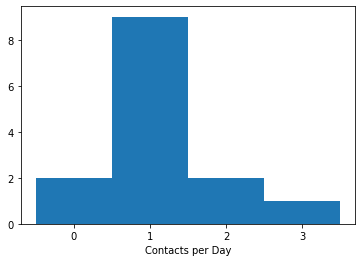

In [19]:
plt.hist(contacts, bins=np.arange(contacts.max() + 2) - 0.5)
plt.xticks(range(contacts.max() + 1))
plt.xlabel('Contacts per Day')
plt.show()

The results above are based on a very small sample size. We can expand the sample by continuing to isolate the initial infected dot but increasing the simulation length. 

The code above has been factored into a helper function `contacts_of_init_inf`.

In [20]:
from rknot import Sim

params = dict(
    density=1,
    R0=2.5,
    infdur=14,
    days=100,
)

sim = Sim(groups=group, **params)
sim.run(dotlog=True)

In [21]:
from rknot.helpers import contacts_of_init_inf

contacts = contacts_of_init_inf(sim.dotlog)
mean = np.mean(contacts)
var = np.var(contacts)

In [22]:
if UPDATEDB:
    db['mean, var 2'] = (mean, var, contacts)
mean, var, contacts =  db['mean, var 2']

In [23]:
print (mean, var)

0.9850746268656716 1.0594787257741147


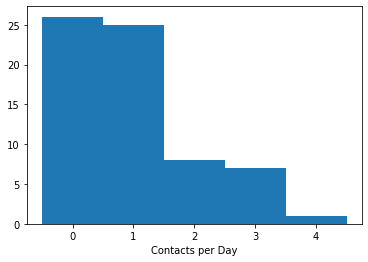

In [24]:
plt.hist(contacts, bins=np.arange(contacts.max() + 2) - 0.5)
plt.xticks(range(contacts.max() + 1))
plt.xlabel('Contacts per Day')
plt.show()

Again, we find a similar average contact rate and variance, although the histogram shape is altered somewhat.

For an even larger sample, we can repeat the above process for every dot in the simulation. The `find_all_contacts` method loops through every dot in the dotlog and finds the number of contacts for each dot.

In [25]:
from rknot.dots.matrix import MLNB

all_contacts = find_all_contacts(sim.dotlog[:14], MLNB)
mean = all_contacts.mean()
var = all_contacts.var()

In [27]:
if UPDATEDB:
    db['mean, var 3'] = (mean, var, all_contacts)
mean, var, all_contacts = db['mean, var 3']

In [28]:
print (mean, var)

0.9914285714285714 1.1613551020408164


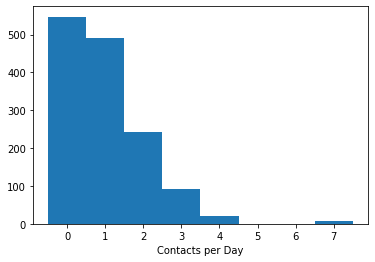

In [29]:
plt.hist(all_contacts, bins=np.arange(all_contacts.max() + 2) - 0.5, density=False)
plt.xticks(range(all_contacts.max() + 1))
plt.xlabel('Contacts per Day')
plt.show()

We find that all the dots in the sim had a mean contact rate near 1 (as expected) and variance near 1.

Yet another approach is to iterate over a number of different sims and look for the mean and variance of contacts for the infected dot across those sims. For faster runtime, we can pass the completed workers of one Sim on the next. This ensures Numba functions need only be loaded once for the whole loop.

In [30]:
from tqdm.auto import trange

days = 14
params = {'density':1, 'R0': 2.5, 'infdur': 14, 'days': days}

n = 50
contacts = np.zeros(days*n, dtype=np.int32)
for i in trange(n):
    if i == 0:
        sim = Sim(groups=group, **params)
    else:
        sim = Sim(groups=group, server=sim.server, workers=sim.workers, **params)
    
    if i == n-1:
        sim.run(dotlog=True, pbar_leave=False, kill=True)
    else:
        sim.run(dotlog=True, pbar_leave=False, kill=False)
        
    inf_contacts = contacts_of_init_inf(sim.dotlog)
    contacts[i*days:i*days + days] = inf_contacts

mean, var = contacts.mean(), contacts.var()

In [32]:
if UPDATEDB:
    db['mean, var 3'] = (mean, var, contacts)
mean, var, contacts = db['mean, var 3']

In [31]:
print (round(contacts.mean(),2), contacts.reshape(-1,14).sum(axis=1).mean())

1.01 14.18


Above we see that the infected dot average close to 1 contact per day or 14 contacts over the duration of the infection.

#### SIR: Confirming $R_0$ ####

We can similarly use the dotlog to confirm that the simulation results in the correct level of $R_0$, whether passed explicitly or implied through other parameters.

We can measure the *expected* $R_0$ of an infected dot, in any environment, by determining its number of contacts and then multiplying those contacts by the tranmission risk at the time of the contacts. This results in the expected number of transmissions per day, which is then summed.

In [34]:
params = dict(
    density=1,
    R0=2.5,
    infdur=14,
    days=20,
)
group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='equal',
)
sim = Sim(groups=group, **params)
sim.run(dotlog=True)

In [35]:
contacts = find_all_contacts(sim.dotlog[:sim.tmrs.shape[0]], MLNB)
contacts_by_dot = contacts.reshape(-1, sim.tmrs.shape[0])
eR0_by_dot = sim.tmrs * contacts_by_dot

In [36]:
np.sum(eR0_by_dot, axis=1).mean()

2.4891428571428533

So based on the actual contacts had by each dot in the environment, we would expect any particular dot to create ~2.5 secondary infections, equivalent to $R_0$ of 3.

With that in mind, we can investigate if this actually occurs. Again, we can find the ids that had contact with the infected dot at each tick.

In [37]:
i_inf = np.argwhere(sim.dotlog[0][:, ML['is_inf']] == 1).ravel()
locs_visited = sim.dotlog[:, i_inf, ML['loc_id']].ravel()
dots_at_loc = sim.dotlog[:,:,ML['loc_id']] == locs_visited[:, None]

Now, we will check each dots' `is_inf` attribute *before* and *after* the contact occurs.

Remember, transmission is the last step in each tick and that the dot matrix is update at the beginning of each tick. So, the status of the dot at tick i is its status *before* contact.

We sum the dots infected before and subtract the dots infected after, which gives the dots infected at that contact.

In [44]:
i_contact = np.argwhere(dots_at_loc[:sim.dotlog.shape[0]-1])
i_contact = i_contact[i_contact[:,1] != i_inf]

infs_pre = sim.dotlog[i_contact[:, 0], i_contact[:, 1], ML['is_inf']].sum()
fwd_inf = i_contact + [1, 0]
infs_post = sim.dotlog[fwd_inf[:,0], fwd_inf[:,1], ML['is_inf']].sum()

# Number of secondary infections created by the initial infected dot
n_sec = infs_post - infs_pre

In [46]:
if UPDATEDB:
    db['nsec 1 run'] = n_sec
n_sec = db['nsec 1 run']

In [47]:
msg = 'The sim above resulted in {} infections.'.format(n_sec)
md(msg)

The sim above resulted in 4 infections.

*The code used above has been factored into the function `find_n_sec`.*

Again, transmission is stochastic and, particularly, small poulations can have highly variable results. We can find a more useful mean by averaging the $R_0$ over many simulations. 

First, we can use `find_all_contacts` to estimate the mean number of secondary infections we would expect across multiple simulations.

In [48]:
from rknot.helpers import find_n_sec

infdur = 14
days = infdur + 1
n = 150
params = {'density': 1, 'R0': 2.5, 'infdur': infdur, 'days': days}

contacts = np.zeros(infdur*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    if i == 0:
        sim = Sim(groups=group, **params)
    else:
        sim = Sim(groups=group, server=sim.server, workers=sim.workers, **params)
    
    if i == n-1:
        sim.run(dotlog=True, pbar_leave=False, kill=True)
    else:
        sim.run(dotlog=True, pbar_leave=False, kill=False)
        
    n_secs[i] = find_n_sec(sim.dotlog[:infdur+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:infdur])
    contacts[i*infdur:i*infdur + infdur] = inf_contacts

mean, var = n_secs.mean(), n_secs.var()

In [49]:
if UPDATEDB:
    db['nsecs mean, var 1'] = (n_secs.mean(), n_secs.var(), contacts)
mean, var, contacts = db['nsecs mean, var 1']

In [50]:
print (mean, var, contacts.reshape(-1,14).sum(axis=1).mean())

2.2866666666666666 2.351155555555555 14.113333333333333


In [51]:
np.around((contacts.reshape(-1,14).mean(axis=0)*sim.tmrs).sum())

2.0

We see here that, across 150 sims, the $R_0$ is ~15% below the expected 2.5. Potential biases or sources of error are being investigated.

We can see that the number of contacts is as expected and should result, over time, in mean $R_0$ of 2.5

#### SIR: Impact of Changes in Mover Function ###

With the veracity of the SIR model and the assessment process confirmed, we can check the impact of changes to various attributes of the sim, including the `mover` function.

In [53]:
group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='local',
)

infdur = 14
days = infdur + 1
params = {'density': 1, 'R0': 2.5, 'infdur': infdur, 'days': days}
days = infdur + 1

n = 150
contacts = np.zeros(infdur*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    if i == 0:
        sim = Sim(groups=group, **params)
    else:
        sim = Sim(groups=group, server=sim.server, workers=sim.workers, **params)
    
    if i == n-1:
        sim.run(dotlog=True, pbar_leave=False, kill=True)
    else:
        sim.run(dotlog=True, pbar_leave=False, kill=False)

    n_secs[i] = find_n_sec(sim.dotlog[:infdur+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:infdur])
    contacts[i*infdur:i*infdur + infdur] = inf_contacts
    
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = n_secs.mean(), n_secs.var()

(pid=raylet) E1112 02:16:50.956784 76782 392058304 node_manager.cc:3671] Failed to send get core worker stats request: IOError: 14: Connection reset by peer
(pid=raylet) E1112 02:16:50.959090 76782 392058304 node_manager.cc:3671] Failed to send get core worker stats request: IOError: 14: Connection reset by peer
(pid=raylet) E1112 02:16:50.961355 76782 392058304 node_manager.cc:3671] Failed to send get core worker stats request: IOError: 14: Connection reset by peer
(pid=raylet) E1112 02:16:50.961652 76782 392058304 node_manager.cc:3671] Failed to send get core worker stats request: IOError: 14: Connection reset by peer
(pid=raylet) E1112 02:16:50.962741 76782 392058304 node_manager.cc:3671] Failed to send get core worker stats request: IOError: 14: Connection reset by peer
(pid=raylet) E1112 02:16:50.962986 76782 392058304 node_manager.cc:3671] Failed to send get core worker stats request: IOError: 14: Connection reset by peer
(pid=raylet) E1112 02:16:50.965473 76782 392058304 node_ma

In [55]:
if UPDATEDB:
    db['contacts mean, var local'] = (contacts.mean(), contacts.var(), contacts)
    db['nsecs mean, var local'] = (n_secs.mean(), n_secs.var())

mean_ktr, var_ktr, contacts = db['contacts mean, var local']
mean_nsec, var_nsec = db['nsecs mean, var local']

In [56]:
print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)

1.0876190476190477 1.0285133786848073
2.3533333333333335 2.841822222222222


In [60]:
eR0 = np.mean(contacts.reshape(-1,15)[:,:14]*sim.tmrs, axis=0).sum()
print (round(eR0, 2))

2.69


Despite the signficant change in movement pattern, [which we know results in a very different infection curve](sir.ipynb#2.-Local), the $R_0$ does not decline significantly. In fact, it increases.

#### Customization ####

We can use this testing approach to build custom simulation environments.

For example, in this [paper](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf), the authors fit a transmission risk profile of sars-cov-2 to several properties of the environment including:
+ mean $R_0$ of 1.8
+ 4 contacts per day
+ 40 variance of contacts

RKnot's event structure can help to simulate the required level of variance.
We can import the tmr curve from `rknot.dots.fhutch`.

As with above, we will first investigate the expected number of contacts and secondary infections using `find_all_contacts` under the usual density of 1.

In [61]:
from rknot.dots.fhutch import tmr

In [62]:
days = tmr.shape[0] + 1
group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='equal',
)
params = {'density': 1, 'inf_curve': tmr,  'days': days}
sim = Sim(groups=group, **params)
sim.run(dotlog=True)

In [63]:
contacts = find_all_contacts(sim.dotlog[:sim.tmrs.shape[0]], MLNB)
contacts_by_dot = contacts.reshape(-1, sim.tmrs.shape[0])

eR0_by_dot = sim.tmrs * contacts_by_dot

eR0_mean = eR0_by_dot.sum(axis=1).mean()
eR0_var = eR0_by_dot.sum(axis=1).var()

In [88]:
if UPDATEDB:
    db['contacts mean, var custo'] = (contacts.mean(), contacts.var())
    db['nsecs mean, var custo'] = (n_secs.mean(), n_secs.var())

mean_ktr, var_ktr = db['contacts mean, var custo']
mean_nsec, var_nsec = db['nsecs mean, var custo']

In [64]:
print (contacts.mean(), contacts.var())
print (eR0_mean, eR0_var)

1.0586666666666666 1.1338915555555555
0.4644794230105825 0.11146491889255927


The expected $R_0$ using density of 1 dot per subject is much lower than the 1.8 target.

We have two options. Use events to significantly increase the number of contacts (and the variance) or increase the density.

We'll start with option 1.

We can replicate the required contact frequency and variance quite simply using events. 

We can maintain the density of 1 subject per location and implement a series of 100 separate events, each with a capacity of 18 subjects, and each recur daily beginning on tick 1.

*Here, we will switch to our `baseus` simulation environment, as its size is more conducive to a higher contact variance.*


In [ ]:
from rknot.events import Event
from rknot.sims import baseus
from rknot.helpers import modulereload

modulereload(baseus)

groups = baseus.groups
groups[2]['n_inf'] = 0

days = tmr.shape[0] + 1
params = dict(
    days=days,
    inf_curve=tmr,
    density=1,
    imndur=365,
)

n = 100
events = []
xs = np.random.choice(np.arange(1,100+1), size=n, replace=False)
ys = np.random.choice(np.arange(1,100+1), size=n, replace=False)
xys = [(x,y) for x,y in zip(xs, ys)]
for i in range(n):
    name = 'event{}'.format(i + 4)
    events.append(
        Event(name=name, xy=xys[i], start_tick=1, groups=[0,1,2,3], capacity=18, recurring=1)
    )

We can chart the capacity of the events over time as per below.

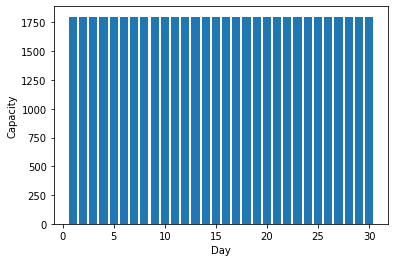

In [74]:
ticks = [i for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]
caps = [e.capacity for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]

from collections import Counter
c = Counter()
for tick, cap in zip(ticks, caps):
    c[tick] += cap

plt.bar(c.keys(), c.values())
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.show()

We can see the event structure proposed has limited variation, but because the density of the simulation is low, this will still lead to significant contact variance.

In [68]:
sim = Sim(groups=groups, events=events, **params)
        
sim.run(dotlog=True)

length = tmr.shape[0]
n_secs = find_n_sec(sim.dotlog[:length+1])
inf_contacts = contacts_of_init_inf(sim.dotlog[:length])

contacts = find_all_contacts(sim.dotlog[:length], MLNB)
contacts_by_dot = contacts.reshape(-1, length)
eR0_by_dot = np.sum(sim.tmrs * contacts_by_dot, axis=1)
eR0_mean = eR0_by_dot.mean()
eR0_var = eR0_by_dot.var()

print (contacts.mean(), contacts.var())
print (eR0_mean, eR0_var)


4.0332333333333334 45.246042212222214
1.888849085421078 5.262518812062303


In [70]:
days = tmr.shape[0] + 1
params['get_attrs'] = False

length = tmr.shape[0]
n = 150
contacts = np.zeros(length*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    if i == 0:
        sim = Sim(groups=groups, events=events, **params)
    else:
        sim = Sim(groups=groups, events=events, server=sim.server, workers=sim.workers, **params)
    
    if i == n-1:
        sim.run(dotlog=True, pbar_leave=False, kill=True)
    else:
        sim.run(dotlog=True, pbar_leave=False, kill=False)

    n_secs[i] = find_n_sec(sim.dotlog[:length+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:length])
    contacts[i*length:i*length + length] = inf_contacts
    
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = n_secs.mean(), n_secs.var()

In [71]:
if UPDATEDB:
    db['contacts mean, var 4'] = (contacts.mean(), contacts.var(), contacts)
    db['nsecs mean, var 4'] = (n_secs.mean(), n_secs.var())

mean_ktr, var_ktr, contacts = db['contacts mean, var 4']
mean_nsec, var_nsec = db['nsecs mean, var 4']

In [72]:
print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)

3.956888888888889 44.26480809876543
2.1266666666666665 11.083955555555553


In [73]:
np.sum(contacts.reshape(-1,30).mean(axis=0)*tmr)

1.654835388400207

The chart below shows the variability of the infected dots contacts over time.

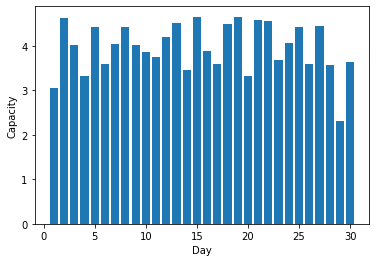

In [77]:
ktr_by_day = contacts.reshape(-1,tmr.shape[0]).mean(axis=0)
plt.bar(np.arange(1, tmr.shape[0] + 1), ktr_by_day)
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.show()

We can see above the expected contacts is close to 4, variance is close to 40, and the $R_0$ is close to the suggested 1.8.

While that is a good outcome, the event structure chosen can be improved upon and made (perhaps) a bit more realistic in terms variability.

To do so, we increase the density to 3.

In [78]:
from rknot.events import Event
from rknot.sims import baseus
from rknot.helpers import modulereload

modulereload(baseus)

groups = baseus.groups
groups[2]['n_inf'] = 0

days = tmr.shape[0] + 1
params = dict(
    days=days,
    inf_curve=tmr,
    density=3,
    imndur=365,
)
import math
square = math.ceil(math.sqrt(10000/3))

n = square
events = []
xs = np.random.choice(np.arange(1,n+1), size=n, replace=False)
ys = np.random.choice(np.arange(1,n+1), size=n, replace=False)
xys = [(x,y) for x,y in zip(xs, ys)]
for i in range(n):
    name = f'event{i}'
    capacity = 51 if i%3 else (12 if i%2 else 15)
    recurring = 14 if i%3 else (2 if i%2 else 1)
    start_tick = np.random.randint(1,14,1, dtype=np.int32)
    events.append(
        Event(
            name=name, xy=xys[i], start_tick=start_tick[0],
            groups=[0,1,2,3], 
            capacity=capacity, recurring=recurring
        )
    )

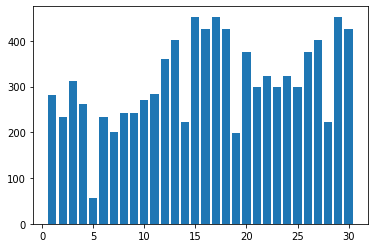

In [79]:
ticks = [i for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]
caps = [e.capacity for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]

from collections import Counter
c = Counter()
for tick, cap in zip(ticks, caps):
    c[tick] += cap

plt.bar(c.keys(), c.values())
plt.show()

In [80]:
sim = Sim(groups=groups, events=events, **params)
        
sim.run(dotlog=True, pbar_leave=True, kill=False)

length = tmr.shape[0]
n_secs = find_n_sec(sim.dotlog[:length+1])
inf_contacts = contacts_of_init_inf(sim.dotlog[:length])

contacts = find_all_contacts(sim.dotlog[:length], MLNB)
contacts_by_dot = contacts.reshape(-1, length)
eR0_by_dot = np.sum(sim.tmrs * contacts_by_dot, axis=1)
eR0_mean = eR0_by_dot.mean()
eR0_var = eR0_by_dot.var()

print (contacts.mean(), contacts.var())
print (eR0_mean, eR0_var)


3.9371133333333335 43.7291319338222
1.8901549029909412 7.093752459158521


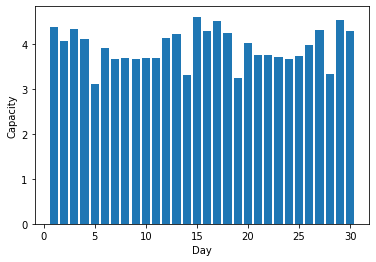

In [81]:
import matplotlib.pyplot as plt
ktr_by_day = contacts.reshape(-1,tmr.shape[0]).mean(axis=0)
plt.bar(np.arange(1, tmr.shape[0] + 1), ktr_by_day)
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.show()

In [82]:
days = tmr.shape[0] + 1
params['get_attrs'] = False

length = tmr.shape[0]
n = 150
contacts = np.zeros(length*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    if i == 0:
        sim = Sim(groups=groups, events=events, **params)
    else:
        sim = Sim(groups=groups, events=events, server=sim.server, workers=sim.workers, **params)
    
    if i == n-1:
        sim.run(dotlog=True, pbar_leave=False, kill=True)
    else:
        sim.run(dotlog=True, pbar_leave=False, kill=False)

    n_secs[i] = find_n_sec(sim.dotlog[:length+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:length])
    contacts[i*length:i*length + length] = inf_contacts
    
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = n_secs.mean(), n_secs.var()

In [86]:
if UPDATEDB:
    db['contacts mean, var 5'] = (contacts.mean(), contacts.var(), contacts)
    db['nsecs mean, var 5'] = (n_secs.mean(), n_secs.var())

mean_ktr, var_ktr, contacts = db['contacts mean, var 5']
mean_nsec, var_nsec = db['nsecs mean, var 5']

In [87]:
print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)

np.sum(contacts.reshape(-1,30).mean(axis=0)*tmr)

3.956888888888889 44.26480809876543
2.32 13.3776


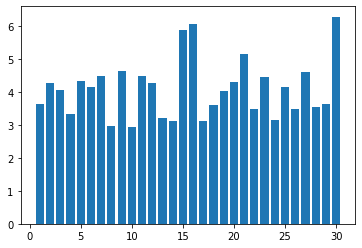

In [63]:
import matplotlib.pyplot as plt
ktr_by_day = contacts.reshape(-1,tmr.shape[0]).mean(axis=0)
plt.bar(np.arange(1, tmr.shape[0] + 1), ktr_by_day)
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.show()

The above simulation fits a simulation environment to root FHUTCH analysis of a sample of indiviudal $R_0$s with mean 1.8.

The team also investigated higher $R_0$s and found that this was optimally found to result from increases in the number of daily contacts, not a change in model parameters (and the viral kinetics they represent). For instance, $R_0$ of 2.8 resulted from 20 dailys contacts and a contact variance of 30.

So, in order to achieve a simulation environment with pre-defined $R_0$, we should simply increase the number of daily contacts whilst also managing the contact variance.

For example, we can adjust the model to approach a $R_0$ of 2.5x (the CDC best case figure).

The easiest approach is to work backwards from the number of required contacts per day. As per below, 5 contacts results in expected $R_0$ of ~2.3.

In [95]:
tmr.sum()*5

2.3368382854639176

Here we will tune the density to 4.75x and also randomly assign groups to events more realistic.

In [142]:
from rknot.events import Event
from rknot.sims import baseus
from rknot.helpers import modulereload

modulereload(baseus)

import math

groups = baseus.groups
groups[2]['n_inf'] = 0

density = 5
days = tmr.shape[0] + 1
params = dict(
    days=days,
    inf_curve=tmr,
    density=4.75,
    imndur=365,
)

square = math.ceil(math.sqrt(10000/density))

n = square
events = []
xs = np.random.choice(np.arange(1,n+1), size=n, replace=False)
ys = np.random.choice(np.arange(1,n+1), size=n, replace=False)
xys = [(x,y) for x,y in zip(xs, ys)]
for i in range(n):
    name = f'event{i}'
    capacity = 60 if i%3 else (12 if i%2 else 21)
    recurring = 14 if i%3 else (2 if i%2 else 1)
    start_tick = np.random.randint(1,14,1, dtype=np.int32)
    
    if capacity == 51:
        potential_groups = [[0,1,2], [1,2], [0,1,2,3]]
        pvals = [0.3, 0.5, 0.2]
        i_groups = np.random.choice([0,1,2], size=1, p=pvals)
    else:
        potential_groups = [[0,1,2], [1,2], [0,1], [2,3], [0], [1], [2], [3]]
        pvals = [0.20, 0.25, 0.15, 0.05, 0.1, 0.1, 0.1, 0.05]
        i_groups = np.random.choice(np.arange(0,8), size=1, p=pvals)
    
    e_groups = potential_groups[i_groups[0]]
    events.append(
        Event(
            name=name, xy=xys[i], start_tick=start_tick[0],
            groups=e_groups, 
            capacity=capacity, recurring=recurring
        )
    )

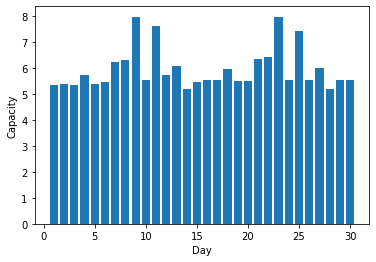

In [143]:
import matplotlib.pyplot as plt
ktr_by_day = contacts.reshape(-1,tmr.shape[0]).mean(axis=0)
plt.bar(np.arange(1, tmr.shape[0] + 1), ktr_by_day)
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.show()

In [144]:
sim = Sim(groups=groups, events=events, **params)
        
sim.run(dotlog=True, pbar_leave=True, kill=False)

length = tmr.shape[0]
n_secs = find_n_sec(sim.dotlog[:length+1])
inf_contacts = contacts_of_init_inf(sim.dotlog[:length])

contacts = find_all_contacts(sim.dotlog[:length], MLNB)
contacts_by_dot = contacts.reshape(-1, length)
eR0_by_dot = np.sum(sim.tmrs * contacts_by_dot, axis=1)
eR0_mean = eR0_by_dot.mean()
eR0_var = eR0_by_dot.var()

print (contacts.mean(), contacts.var())
print (eR0_mean, eR0_var)


5.7920533333333335 58.73189151715555
2.495657749177992 3.955350983955479


In [145]:
days = tmr.shape[0] + 1
params['get_attrs'] = False

length = tmr.shape[0]
n = 150
contacts = np.zeros(length*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    if i == 0:
        sim = Sim(groups=groups, events=events, **params)
    else:
        sim = Sim(groups=groups, events=events, server=sim.server, workers=sim.workers, **params)
    
    if i == n-1:
        sim.run(dotlog=True, pbar_leave=False, kill=True)
    else:
        sim.run(dotlog=True, pbar_leave=False, kill=False)

    n_secs[i] = find_n_sec(sim.dotlog[:length+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:length])
    contacts[i*length:i*length + length] = inf_contacts
    
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = n_secs.mean(), n_secs.var()

(pid=77478) 2020-11-12 03:23:39,491	INFO (unknown file):0 -- gc.collect() freed 7 refs in 0.2395530600000484 seconds


In [146]:
if UPDATEDB:
    db['contacts mean, var 6'] = (contacts.mean(), contacts.var(), contacts)
    db['nsecs mean, var 6'] = (n_secs.mean(), n_secs.var())

mean_ktr, var_ktr, contacts = db['contacts mean, var 6']
mean_nsec, var_nsec = db['nsecs mean, var 6']

In [147]:
print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)

np.sum(contacts.reshape(-1,30).mean(axis=0)*tmr)

6.103555555555555 70.92616513580246
5.68 50.08426666666667


2.5221427327822727

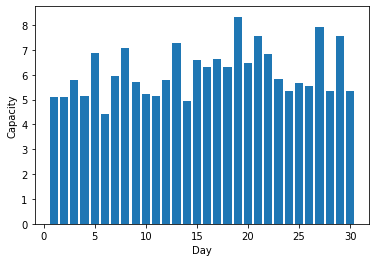

In [148]:
import matplotlib.pyplot as plt
ktr_by_day = contacts.reshape(-1,tmr.shape[0]).mean(axis=0)
plt.bar(np.arange(1, tmr.shape[0] + 1), ktr_by_day)
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.show()

In [149]:
%%javascript
 IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [150]:
from rknot.helpers import move_to_doc_folder
move_to_doc_folder('sizing.ipynb')